# **LED Lifetime Prediction**

----

## **0. Import data & library**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd

In [ ]:
dataset = pd.read_excel('/content/li_vi_organised_reshaped.xlsx')
dataset.head()

,LED,temperature,stressing current,performing hour,input voltage,reverse saturated current,light intensity
0,A,25,40,0.0,-5.00,-5.270000e-10,2517
1,A,25,40,0.0,-4.95,-5.180000e-10,2517
2,A,25,40,0.0,-4.90,-5.210000e-10,2517
3,A,25,40,0.0,-4.85,-5.220000e-10,2517
4,A,25,40,0.0,-4.80,-5.160000e-10,2517


----
## **Model4: Overfitting Prevent**
### **Model3 improvement (dropout & L2 regularization， reducing number of hidden layer)**
refence: Dropout: A Simple Way to Prevent Neural Networks from
Overfitting
https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [ ]:
indexNames = dataset[ (dataset['temperature'] == 25)
                & (dataset['stressing current'] == 60)& (dataset['performing hour']>=15) ].index
df_dropped=dataset.drop(indexNames).reset_index().iloc[:,1:]
indexNames = df_dropped[ (df_dropped['temperature'] == 60)
                & (df_dropped['stressing current'] == 60)& (df_dropped['performing hour']>=11) ].index
df_dropped=df_dropped.drop(indexNames).reset_index().iloc[:,1:]
from sklearn.utils import shuffle
df_dropped=shuffle(df_dropped)
df_dropped['temperature']=df_dropped['temperature']+273
df_dropped

,LED,temperature,stressing current,performing hour,input voltage,reverse saturated current,light intensity
63314,E,298,40,10.0,5.00,1.000032e-01,3457
38953,C,298,100,0.0,3.00,1.133025e-02,3891
31411,C,298,40,4.0,-2.25,-5.130000e-10,2763
49633,D,298,60,8.0,4.35,1.000045e-01,2158
64714,E,298,60,7.0,4.65,1.000046e-01,1889
...,...,...,...,...,...,...,...
50028,D,298,60,10.0,4.00,8.978590e-02,2227
23572,B,298,100,0.0,-2.25,-5.700000e-10,4095
58288,D,333,80,1.0,4.95,9.999140e-02,0
62054,E,298,40,4.0,2.30,5.940000e-07,3912


In [ ]:
indexNames = df_dropped[ (df_dropped['temperature'] == 25)
                & (df_dropped['stressing current'] == 60)& (df_dropped['performing hour']>=15) ].index
df_dropped=df_dropped.drop(indexNames).reset_index().iloc[:,1:]

In [ ]:
#add row with LI=0
t=0
new=pd.DataFrame(columns=['LED','temperature','stressing current','performing hour','input voltage','reverse saturated current','light intensity'])
for row,content in df_dropped[df_dropped['light intensity']==0].iterrows():
  if t%1000==0:
    print(t)
  if t>20000:
    break
  else:
    t+=1
  LED=content[0]
  temperature=content[1]
  current=content[2]
  hour=content[3]
  voltage=content[4]
  rsc=content[5]
  for h in range(1,5):
    new=new.append({'LED':LED,
            'temperature':temperature,
            'stressing current':current,
            'performing hour':hour+h,
            'input voltage':voltage,
            'reverse saturated current':rsc,'light intensity':0},ignore_index=True)
new=new.drop_duplicates()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [ ]:
df_dropped=pd.concat([df_dropped,new]).drop_duplicates()
df_dropped

,LED,temperature,stressing current,performing hour,input voltage,reverse saturated current,light intensity
0,E,298,40,10.0,5.00,1.000032e-01,3457
1,C,298,100,0.0,3.00,1.133025e-02,3891
2,C,298,40,4.0,-2.25,-5.130000e-10,2763
3,D,298,60,8.0,4.35,1.000045e-01,2158
4,E,298,60,7.0,4.65,1.000046e-01,1889
...,...,...,...,...,...,...,...
23984,A,298,80,10.0,4.25,1.000003e-01,0
23985,A,298,80,11.0,4.25,1.000003e-01,0
23986,A,298,80,12.0,4.25,1.000003e-01,0
23987,A,298,80,13.0,4.25,1.000003e-01,0


In [ ]:
X = df_dropped.iloc[:,1:5].values
X=np.asarray(X).astype('float32')
y = df_dropped.iloc[:,6].values
y=np.asarray(y).astype('float32')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from keras import regularizers
import keras
optimizer_list=[    ('SGD',keras.optimizers.SGD(0.001)),
            ('Adam',keras.optimizers.Adam(0.001)),
            ('Nadam',keras.optimizers.Nadam(0.001)),
            ('RMSprop',keras.optimizers.RMSprop(0.001))]

regularizers_list=[   ('L2',regularizers.l2(0.01)),
            ('L1',regularizers.l1(0.01))]

In [ ]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
result_list=[]
for optimizer_pair in optimizer_list:
  for regularizers_pair in regularizers_list:
    optimizer_name = optimizer_pair[0]
    regularizer_name = regularizers_pair[0]
    optimizer = optimizer_pair[1]
    regularizer = regularizers_pair[1]
    # Initialising the DNN
    model4 = Sequential()

    # Adding the input layer and the first hidden layer
    model4.add(Dense(units = 12, activation = 'relu', input_dim = 4, kernel_regularizer= regularizer))
    model4.add(Dropout(0.2))
    model4.add(Dense(units = 12, activation = 'relu', kernel_regularizer= regularizer))
    model4.add(Dense(units = 12, activation = 'relu', kernel_regularizer= regularizer))
    model4.add(Dense(units = 12, activation = 'relu', kernel_regularizer= regularizer))
    model4.add(Dense(units = 12, activation = 'relu', kernel_regularizer= regularizer))


    # Adding the output layer
    model4.add(Dense(units = 1, activation = 'relu'))

    # Compiling the DNN
    model4.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse','mae'])

    # Fitting the DNN to the Training set
    history = model4.fit(X_train, y_train, batch_size = 100, epochs = 50, validation_split = 0.2,verbose=1)
    result_list.append([ optimizer_name, regularizer_name, history, model4, history.history['val_mae'][-1] ])

Epoch 1/50
637/637 [==============================] - 2s 2ms/step - loss: 2892310.7057 - mse: 2892308.6019 - mae: 1101.0682 - val_loss: 2917214.7500 - val_mse: 2917213.2500 - val_mae: 1111.0563
Epoch 2/50
637/637 [==============================] - 1s 1ms/step - loss: 2913170.9353 - mse: 2913169.4044 - mae: 1109.3845 - val_loss: 2917214.7500 - val_mse: 2917213.2500 - val_mae: 1111.0563
Epoch 3/50
637/637 [==============================] - 1s 1ms/step - loss: 2895167.0059 - mse: 2895165.0741 - mae: 1102.9583 - val_loss: 2917214.7500 - val_mse: 2917213.2500 - val_mae: 1111.0563
Epoch 4/50
637/637 [==============================] - 1s 1ms/step - loss: 2901865.4291 - mse: 2901863.8777 - mae: 1104.9677 - val_loss: 2917214.7500 - val_mse: 2917213.2500 - val_mae: 1111.0563
Epoch 5/50
637/637 [==============================] - 1s 1ms/step - loss: 2879816.5827 - mse: 2879815.0909 - mae: 1097.9988 - val_loss: 2917214.7500 - val_mse: 2917213.2500 - val_mae: 1111.0563
Epoch 6/50
637/637 [==========

In [ ]:
result_list

[['SGD',
  'L2',
  1111.0562744140625],
 ['SGD',
  'L1',
  1111.0562744140625],
 ['Adam',
  'L2',
  322.62103271484375],
 ['Adam',
  'L1',
  297.0278015136719],
 ['Nadam',
  'L2',
  326.1846618652344],
 ['Nadam',
  'L1',
  325.53515625],
 ['RMSprop',
  'L2',
  281.5153503417969],
 ['RMSprop',
  'L1',
  263.8121337890625]]

SGD L1


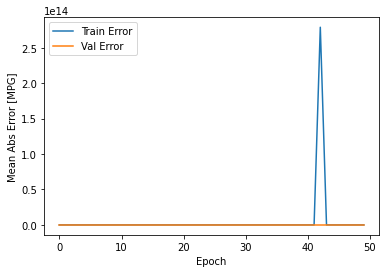

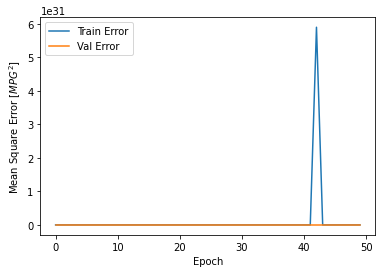

SGD L2


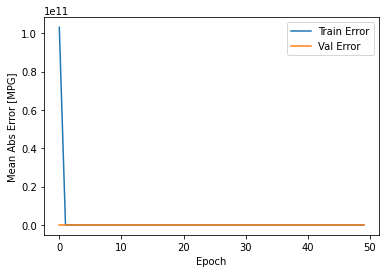

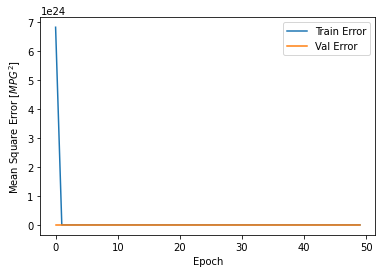

Adam L1


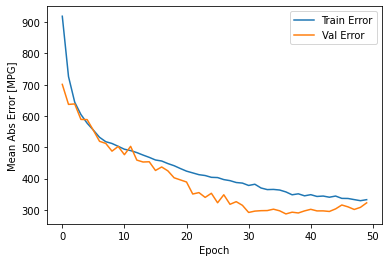

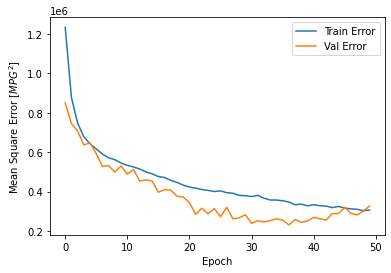

Adam L2


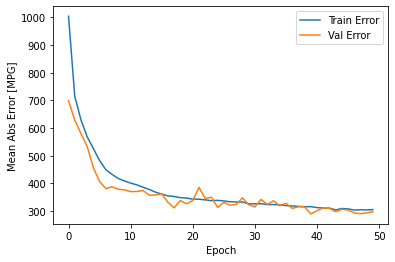

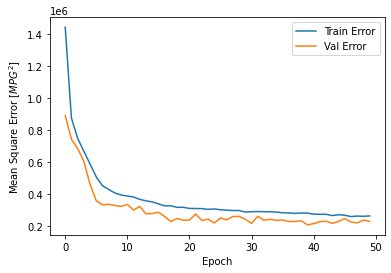

Nadam L1


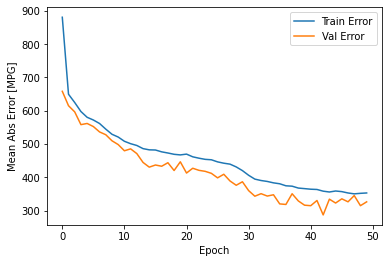

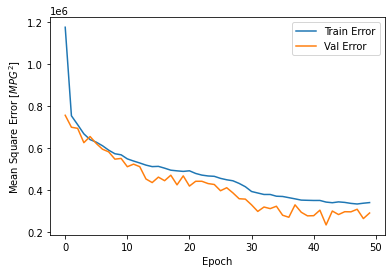

Nadam L2


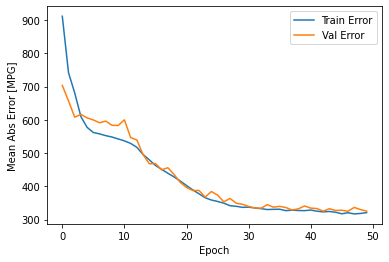

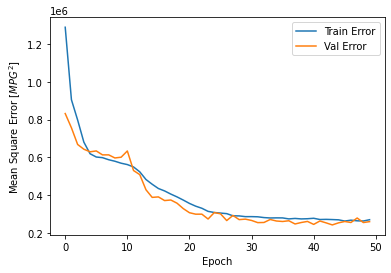

RMSprop L1


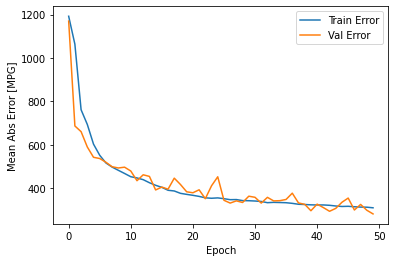

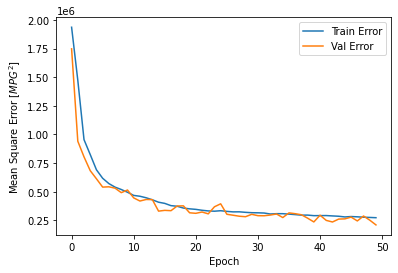

RMSprop L2


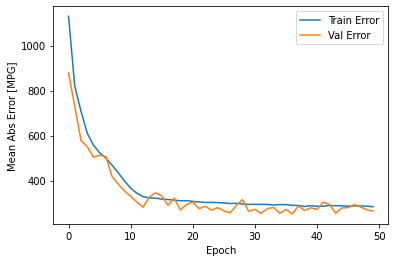

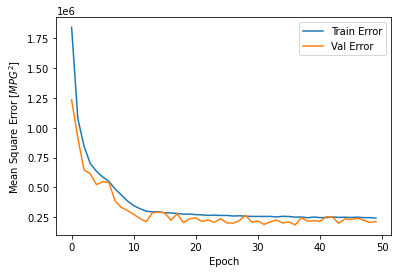

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

for h in result_list:
  print(h[0],h[1])
  plot_history(h[2])

In [ ]:
pd.DataFrame({
    'L1 regularization':[result_list[1][-1],result_list[3][-1],result_list[5][-1],result_list[7][-1]],
    'L2 regularization':[result_list[0][-1],result_list[2][-1],result_list[4][-1],result_list[6][-1]]

},
index=['SGD','Adam','Nadam','RMSprop'])

,L1 regularization,L2 regularization
SGD,1111.056274,1111.056274
Adam,297.027802,322.621033
Nadam,325.535156,326.184662
RMSprop,263.812134,281.515350


In [ ]:
import json
import copy
for r in result_list_tojson:
  #r[2]=r[2].history
  r[3]=r[3].to_json()
with open("result_list.json","w") as f:
  json.dump(result_list_tojson,f)

In [ ]:
import pprint
with open("result_list.json","r") as f:
  pprint.pprint(json.load(f))

[['SGD',
  'L2',
  {'loss': [2916938.75,
            2916938.5,
            2916936.5,
            2916939.25,
            2916936.5,
            2916935.5,
            2916937.75,
            2916937.0,
            2916938.0,
            2916936.25,
            2916936.25,
            2916938.75,
            2916936.75,
            2916936.75,
            2916936.0,
            2916938.0,
            2916939.25,
            2916936.0,
            2916936.75,
            2916937.75,
            2916937.75,
            2916935.5,
            2916938.0,
            2916938.0,
            2916936.25,
            2916938.25,
            2916937.5,
            2916936.5,
            2916938.0,
            2916936.25,
            2916937.5,
            2916939.25,
            2916937.25,
            2916938.25,
            2916937.75,
            2916937.0,
            2916939.25,
            2916937.5,
            2916937.25,
            2916938.75,
            2916935.25,
            29169